In [1]:
# train the FC layer by Adadelta before fine-tuning, and save the weights as TL_VGG_Res_13.h5

import keras
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Model
from keras.layers import *
from keras.optimizers import Adadelta
from keras.preprocessing.image import ImageDataGenerator
import h5py


heights = 224
widths = 224
batch_size = 16
epochs = 10

input_tensor = Input((heights, widths, 3))
x = input_tensor
base_model1 = VGG16(input_tensor=x, weights='imagenet', include_top=False)
base_model2 = ResNet50(input_tensor=x, weights='imagenet', include_top=False)

x1 = base_model1.output
x2 = base_model2.output

x1 = GlobalAveragePooling2D()(x1)
x2 = GlobalAveragePooling2D()(x2)

x = keras.layers.concatenate([x1, x2])

x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)

predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=input_tensor, outputs=predictions)

for layer in base_model1.layers[:]:
    layer.trainable = False

for layer in base_model2.layers[:]:
    layer.trainable = False

model.summary()


# prepare data augmentation configuration

def preprocess_input_new(x):
    
    X = np.expand_dims(x, axis=0)
    X = preprocess_input(X)
    return X[0]

batch_size = 16
train_datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        fill_mode='nearest',
        horizontal_flip=True,
        rotation_range = 30,
        preprocessing_function=preprocess_input_new 
)

validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input_new)

train_generator = train_datagen.flow_from_directory(
    'train_new/',
    target_size=(heights, widths),
    batch_size=batch_size,
    class_mode='binary',
)


validation_generator = validation_datagen.flow_from_directory(
    'validation_new/',
    target_size=(heights, widths),
    batch_size=batch_size,
    class_mode='binary',
    )

#sgd = SGD(lr=1e-4, momentum=0.9, nesterov=True)

model.compile(optimizer = 'adadelta', loss='binary_crossentropy', metrics=['accuracy'])

#model.load_weights('TL_VGG_Res_3.h5')

history = model.fit_generator(
    train_generator,
    epochs = epochs,
    steps_per_epoch = 20000/batch_size,
    validation_data = validation_generator, validation_steps = 5000/batch_size)

#json_string = model.to_json()
#open('TL_VGG16_model_architecture_1.json','w').write(json_string)
model.save_weights('TL_VGG_Res_13.h5')

Using TensorFlow backend.


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D) (None, 230, 230, 3)   0           input_1[0][0]                    
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 112, 112, 64)  9472        zero_padding2d_1[0][0]           
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, 112, 112, 64)  256         conv1[0][0]                      
___________________________________________________________________________________________

In [ ]:
# load the weight "TL_VGG_Res_13.h5", and fine-tune the last layers of VGG16 and ResNet50

import keras
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Model
from keras.layers import *
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
import h5py


heights = 224
widths = 224
batch_size = 16
epochs = 10

input_tensor = Input((heights, widths, 3))
x = input_tensor
base_model1 = VGG16(input_tensor=x, weights='imagenet', include_top=False)
base_model2 = ResNet50(input_tensor=x, weights='imagenet', include_top=False)

x1 = base_model1.output
x2 = base_model2.output

x1 = GlobalAveragePooling2D()(x1)
x2 = GlobalAveragePooling2D()(x2)

x = keras.layers.concatenate([x1, x2])

x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)

predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=input_tensor, outputs=predictions)

for layer in base_model1.layers[0:15]:
    layer.trainable = False

for layer in base_model2.layers[0:-10]:
    layer.trainable = False

model.summary()


# prepare data augmentation configuration

def preprocess_input_new(x):
    
    X = np.expand_dims(x, axis=0)
    X = preprocess_input(X)
    return X[0]

batch_size = 16
train_datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        fill_mode='nearest',
        horizontal_flip=True,
        rotation_range = 30,
        preprocessing_function=preprocess_input_new 
)

validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input_new)

train_generator = train_datagen.flow_from_directory(
    'train_new/',
    target_size=(heights, widths),
    batch_size=batch_size,
    class_mode='binary',
)


validation_generator = validation_datagen.flow_from_directory(
    'validation_new/',
    target_size=(heights, widths),
    batch_size=batch_size,
    class_mode='binary',
    )

#we need to use SGD with a lower learning rate to fine-tune the model
sgd = SGD(lr=1e-4, momentum=0.9, nesterov=True)

model.compile(optimizer = sgd, loss='binary_crossentropy', metrics=['accuracy'])

#load the weights trained before
model.load_weights('TL_VGG_Res_13.h5')

history = model.fit_generator(
    train_generator,
    epochs = epochs,
    steps_per_epoch = 20000/batch_size,
    validation_data = validation_generator, validation_steps = 5000/batch_size)

#json_string = model.to_json()
#open('TL_VGG16_model_architecture_1.json','w').write(json_string)
model.save_weights('TL_VGG_Res_14.h5')

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D) (None, 230, 230, 3)   0           input_2[0][0]                    
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 112, 112, 64)  9472        zero_padding2d_2[0][0]           
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, 112, 112, 64)  256         conv1[0][0]                      
___________________________________________________________________________________________

['acc', 'loss', 'val_acc', 'val_loss']


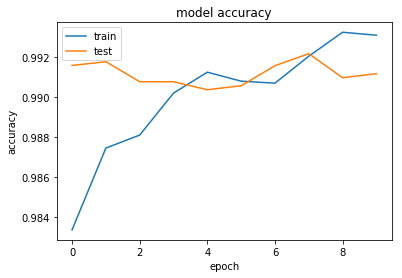

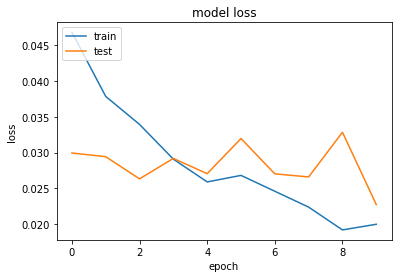

In [3]:
# visualize the training process

import matplotlib.pyplot as plt

# list the data in history
print(history.history.keys())

# summarize history of accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history of loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [4]:
# predict the test dataset

import numpy as np
import os
import csv
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.applications.imagenet_utils import preprocess_input, decode_predictions

namelist = os.listdir('test/')
pre_num = 12500
pre_value = {}
#print pre_value

csvfile = file('pred.csv', 'wb')
writer = csv.writer(csvfile)
writer.writerow(['id', 'label'])

for i in range(pre_num):
    img = load_img('test/' + namelist[i])
    img = img.resize((224, 224))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    preds = preds.clip(min=0.005, max=0.995)
    pre_value[namelist[i][0:-4]] = preds[0][0]
    
for k,v in pre_value.iteritems():
    writer.writerow([k, v])
csvfile.close()